In [19]:
# coding=utf-8
from scapy.all import *
import binascii
import socket, struct
import time

import crcmod
import libnum

from scapy.layers.inet import IP, UDP
from scapy.layers.l2 import Ether

import numpy as np

plc_cube = []
hmi_cube = []

seq = []

def ip2long(ip):
    """
    Convert an IP string to long
    """
    packedIP = socket.inet_aton(ip)
    return struct.unpack("!L", packedIP)[0]

def packet_analysis(pkt):
    if TCP in pkt and IP in pkt:
        if pkt[TCP].seq not in seq:
            d_time = float(str(pkt.time))
            seq.append(pkt[TCP].seq)
            if(pkt[TCP].dport == 44818 and pkt[IP].len > 60):
                s_ip = ip2long(pkt[IP].src)
                d_ip = ip2long(pkt[IP].dst)
                hmi_cube.append(np.asarray([s_ip,d_ip,d_time]))
            if(pkt[TCP].sport == 44818 and pkt[IP].len > 60):
                s_ip = ip2long(pkt[IP].src)
                d_ip = ip2long(pkt[IP].dst)
                plc_cube.append(np.asarray([s_ip,d_ip,d_time]))

In [20]:
try:
    #print(ifaces)
    #sniff(iface="Realtek PCIe GbE Family Controller", prn=packet_analysis, filter="udp port 18507")
    sniff(offline='DataSet/Dex2019_0002_attack3.pcap', prn=packet_analysis, store=0, count=100000)
    plc_cube = np.asarray(plc_cube)
    hmi_cube = np.asarray(hmi_cube)
    print('Completed')

except Exception as sniff_dec_err:
    traceback.print_exc()
    print(str(sniff_dec_err))

Completed


In [21]:
#fourier = np.fft.fft(hmi_cube)

In [22]:
print(hmi_cube.shape)
print(plc_cube.shape)
print(plc_cube[2][0])

(4320, 3)
(4077, 3)
3232235826.0


In [23]:
dst1 = hmi_cube[hmi_cube[:,0]==[ip2long('192.168.1.10')]]
dst2 = dst1[dst1[:,1]==[ip2long('192.168.1.20')]]

In [24]:
#print(dst2.shape)
#print(dst2)
hmi_data = dst1[:,2]
#print(k)

In [25]:
hmi_diff = np.diff(hmi_data)
print(hmi_diff.shape)
#print(hmi_diff)

(2242,)


2000.0
[66.          5.33333333  0.          0.          0.          0.33333333
  2.          2.66666667  6.          6.          5.33333333  1.
  0.          0.          0.          0.          0.          0.
  1.33333333  0.66666667  1.          0.66666667  0.66666667  0.
  0.          0.          0.          0.          0.          0.33333333
  0.66666667  0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  

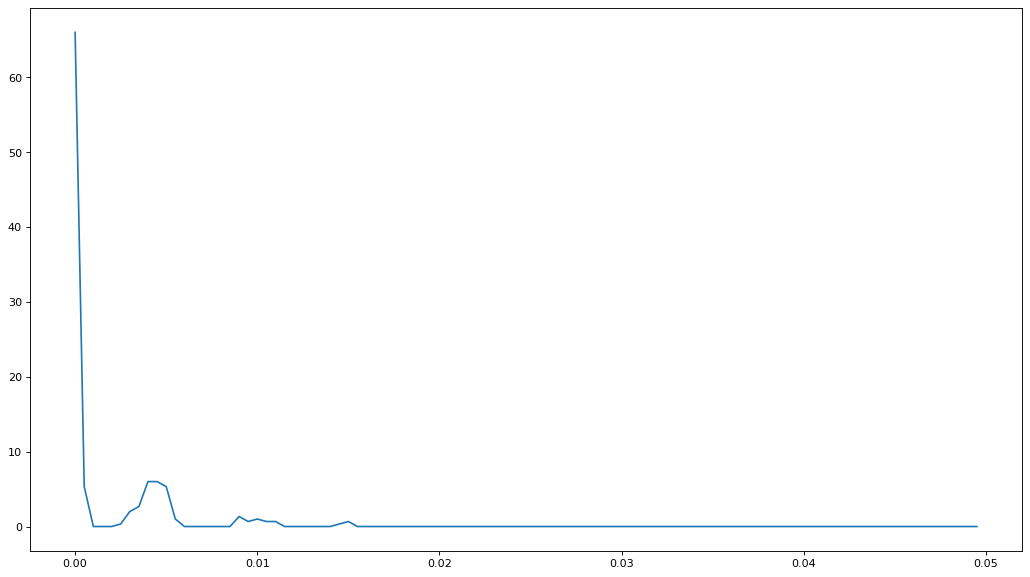

In [32]:
from matplotlib.pyplot import figure
figure(num=None, figsize=(16, 9), dpi=80, facecolor='w', edgecolor='k')

maxrange = 0.05

data = hmi_diff[:300]
hist, bin_edges = np.histogram(data, bins=100, range=(0.0,maxrange), density=True)
bin_edges = bin_edges[:-1]
prob = hist[:]*maxrange
print(sum(hist))
#print(max(prob))
print(prob)
print(np.sum(prob))
mat = np.vstack((prob,bin_edges))

plt.plot(bin_edges,prob)

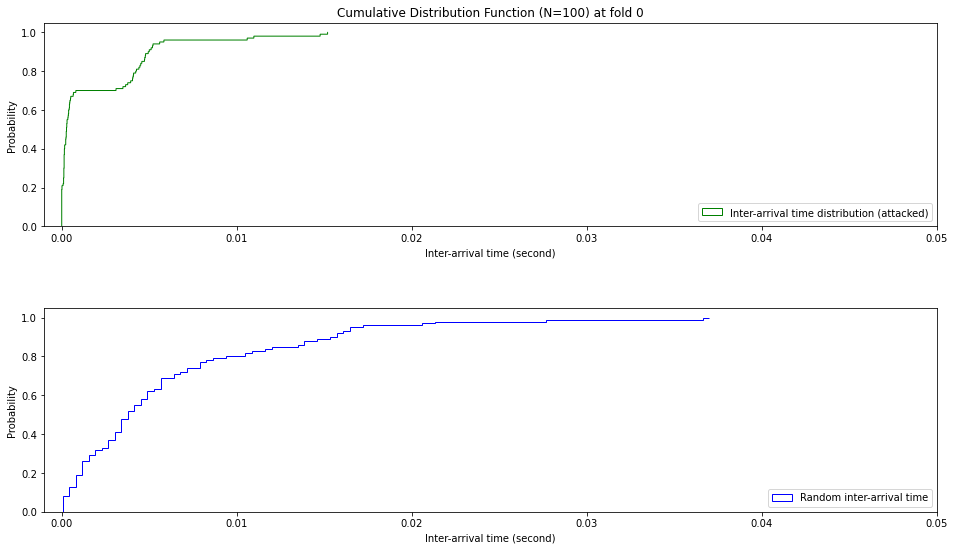

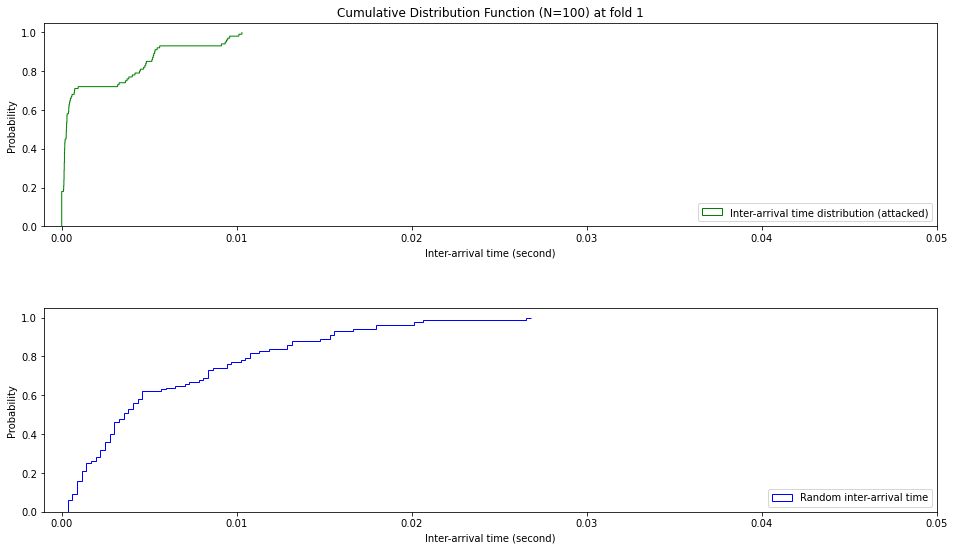

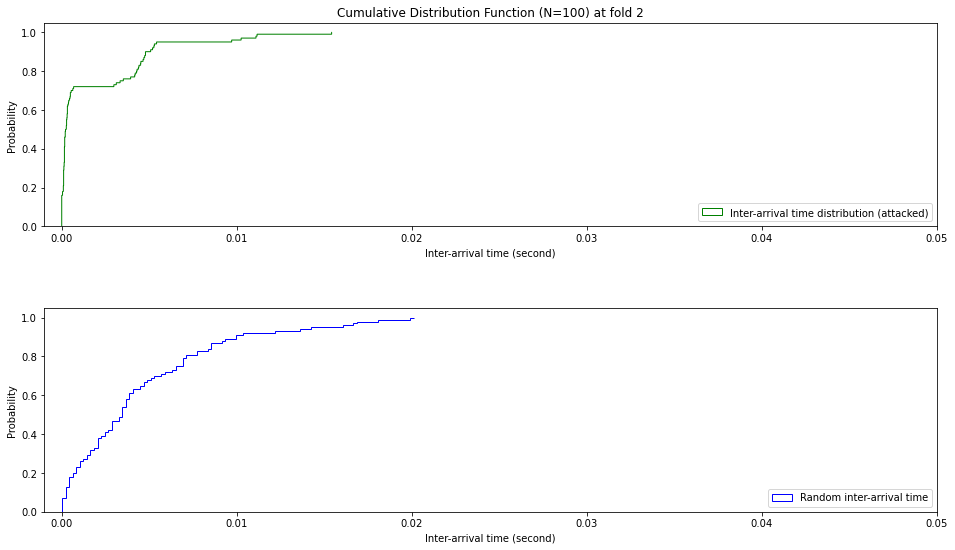

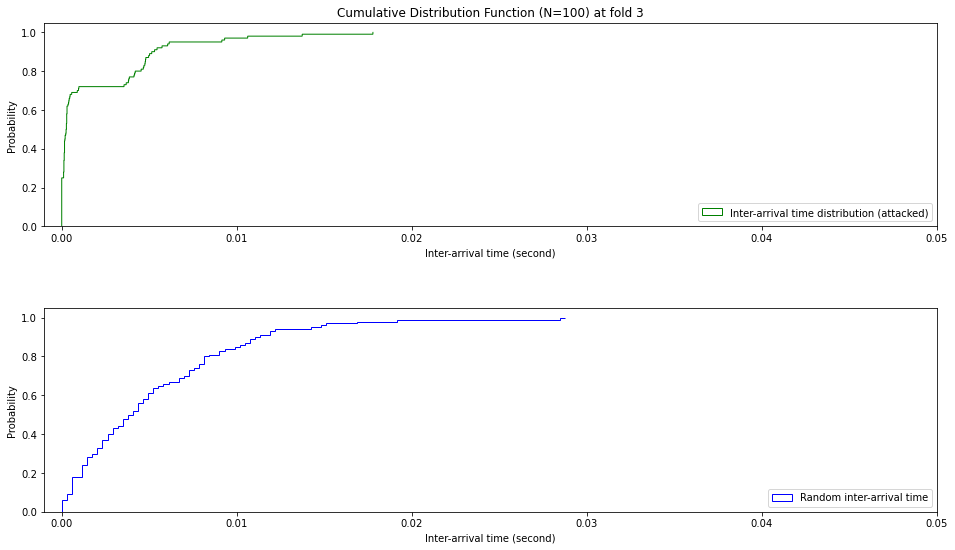

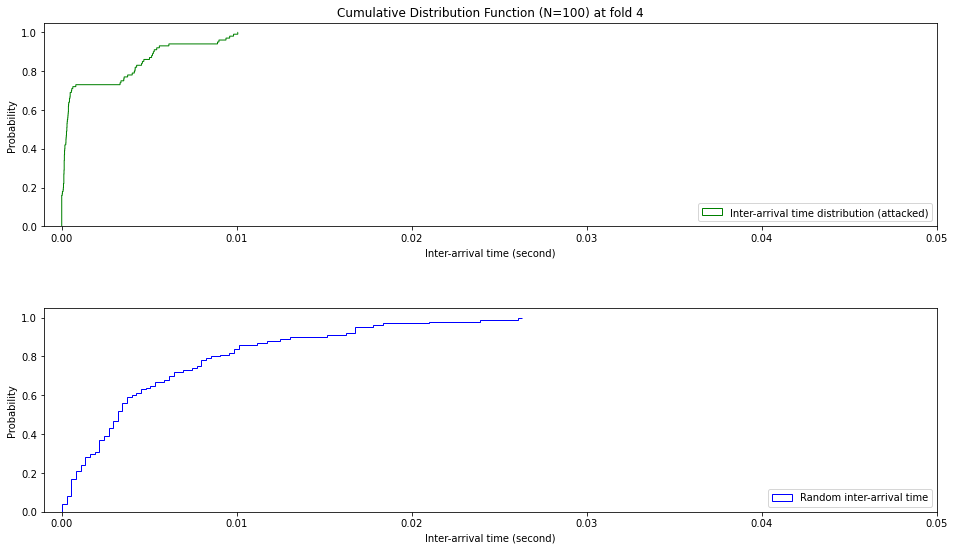

In [27]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
#fig1, ax = plt.subplots()
for k in range(5):

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16,9))
    fig.subplots_adjust(hspace=0.4)

    #### First, plot the empirical result
    fold = k*100
    y = hmi_diff[fold:fold+100]
    n_bins = 1000 #len(y)-1
    n, bins, patches = ax1.hist(y, n_bins, density=True, histtype='step',
              cumulative=True, label='Inter-arrival time distribution (attacked)', color='g')
    # the following line is used to remove the last point
    patches[0].set_xy(patches[0].get_xy()[:-1])
    ax1.set_xlim(-0.001, 0.05)
    ax1.set_xlabel('Inter-arrival time (second)')
    ax1.set_ylabel('Probability')
    ax1.set_title('Cumulative Distribution Function (N='+ str(len(y)) +') at fold ' + str(k))
    ax1.legend(loc=4)

    #### Then plot the theoretical expontential distribution
    G = np.random.default_rng()
    y = G.exponential(scale=0.005, size=len(y))
    # Now, plot the cumulative distributioin function (CDF)
    n_bins = len(y)-1
    n, bins, patches = ax2.hist(y, n_bins, density=True, histtype='step',
              cumulative=True, label='Random inter-arrival time', color='b')
    # the following line is used to remove the last point
    patches[0].set_xy(patches[0].get_xy()[:-1])
    ax2.set_xlim(-0.001, 0.05)
    ax2.set_xlabel('Inter-arrival time (second)')
    ax2.set_ylabel('Probability')
    #ax2.set_title('Cumulative Distribution Function (N=100)')
    ax2.legend(loc=4)

plt.show()
#plt.savefig('./cdf.pdf')

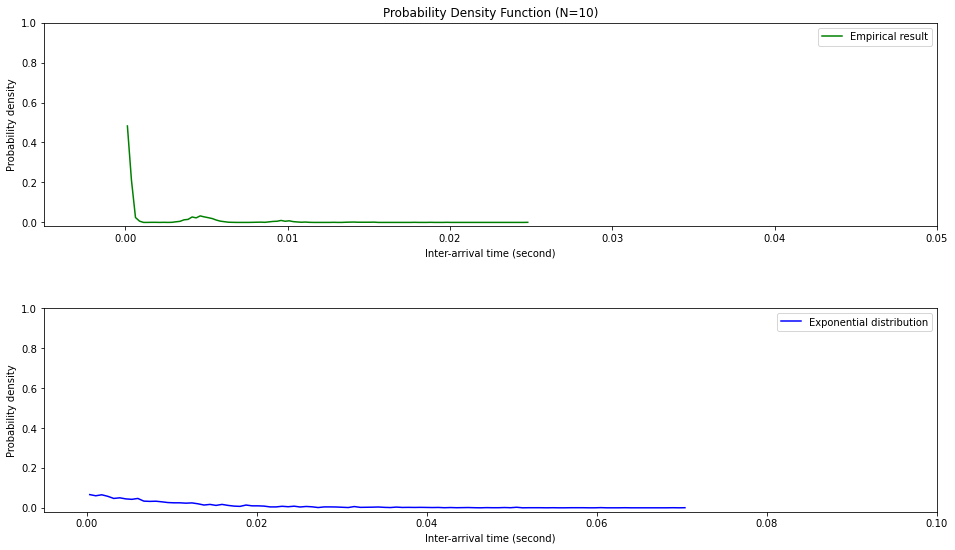

In [28]:
import numpy as np
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16,9))
fig.subplots_adjust(hspace=0.4)

#### First, plot the p.d.f. of our empirical result
y = hmi_diff
heights, bins = np.histogram(y, bins=100)
# do normalization
heights = heights/float(sum(heights))
binMids = bins[:-1]+np.diff(bins)/2.
ax1.plot(binMids, heights, label='Empirical result', color='g')
ax1.set_xlim(-0.005, 0.05)
ax1.set_ylim(-0.02,1.0)
ax1.set_xlabel('Inter-arrival time (second)')
ax1.set_ylabel('Probability density')
ax1.set_title('Probability Density Function (N=10)')
ax1.legend(loc=1)

#### Now, plot the p.d.f. of exponential distribution
G = np.random.default_rng()
y = G.exponential(scale=0.01, size=len(y))
heights, bins = np.histogram(y, bins=100)
# do normalization
heights = heights/float(sum(heights))
binMids = bins[:-1]+np.diff(bins)/2.
ax2.plot(binMids, heights, label='Exponential distribution', color='b')
ax2.set_xlim(-0.005, 0.1)
ax2.set_ylim(-0.02, 1.0)
ax2.set_xlabel('Inter-arrival time (second)')
ax2.set_ylabel('Probability density')
ax2.legend(loc=1)

plt.show()
